### Анализ датасета "Los Angeles Metro Bike Share Trip Data"  из проекта Los Angeles Open Data. 

В этот датасет входят данные о поездках на арендованных велосипедах. Данные являются обезличенными, и сообщают нам о длительности маршрута, его датах и времени, виде поездки, виде тарифного плана (клиента) и координатах поездки за период с июля 2016 г. по апрель 2017 г. Данные получены из открытого источника при помощи API Socrata и Kaggle и предварительно очищены от лишних данных, тестовых и пустых значений.

Основная задача анализа и цель исследования - найти взаимосвязь между показателями поездок и установить что влияет на ее характер в численных значениях. Определить, как повысить эффективность данного бизнеса, увеличить прибыль и сократить издержки.

*Исследовательские задачи:*
- Какая средняя длительность поездки на велосипеде?
- Какие тарифные планы пользуются большей популярностью у покупателей?
- Есть ли какой-то велосипед, который берут чаще? (чтобы узнать какой нужно заменить или отремонтировать)

*Для анализа использовались следующие переменные:*
- Duration - длительность поездки в секундах, была переведена в минуты
- Plan duration - количество дней по плану, приобретенному владельцем карты
- Bike ID - уникальный идентификатор велосипеда
- Trip Route Category - тип маршрута, в одну сторону или туда-обратно
- Start time - время начала поездки
- End time - время конца поездки
- Starting Station ID - точка А маршрута
- Ending Station ID - точка Б маршрута, если значения А и Б совпадают, то это был маршрут туда-обратно, в противном случае в одну сторону



In [135]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction import FeatureHasher
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
names = ['Duration', 'Bike ID', 'Plan Duration', 'Trip Route Category']
dataset = pd.read_csv("D:\los-angeles-metro-bike-share-trip-data\metro-bike-share-trip-data.csv", header = 0, sep = ";" ,
                      low_memory=False)
dataset.head()

,Trip ID,Duration,Start Time,End Time,Starting Station ID,Starting Station Latitude,Starting Station Longitude,Ending Station ID,Ending Station Latitude,Ending Station Longitude,Bike ID,Plan Duration,Trip Route Category
0,1912818,180,2016-07-07T04:17:00,2016-07-07T04:20:00,3014.0,34.056610,-118.23721,3014.0,34.056610,-118.23721,6281.0,30.0,1
1,1919661,1980,2016-07-07T06:00:00,2016-07-07T06:33:00,3014.0,34.056610,-118.23721,3014.0,34.056610,-118.23721,6281.0,30.0,1
2,1933383,300,2016-07-07T10:32:00,2016-07-07T10:37:00,3016.0,34.052898,-118.24156,3016.0,34.052898,-118.24156,5861.0,365.0,1
3,1944197,10860,2016-07-07T10:37:00,2016-07-07T13:38:00,3016.0,34.052898,-118.24156,3016.0,34.052898,-118.24156,5861.0,365.0,1
4,1940317,420,2016-07-07T12:51:00,2016-07-07T12:58:00,3032.0,34.049889,-118.25588,3032.0,34.049889,-118.25588,6674.0,0.0,1


### Какая средняя длительность поездки на велосипеде?

In [136]:
format = "%Y-%m-%dT%H:%M:%S"
start_time = pd.to_datetime(dataset["Start Time"], format=format)
end_time = pd.to_datetime(dataset["End Time"], format=format)
duration = pd.DatetimeIndex(end_time - start_time)
duration = pd.DataFrame(duration.hour*60 + duration.minute) #переводит кололнку с временем в секундах в данные в минутах
duration.describe()

,0
count,132425.000000
mean,24.167159
std,79.571959
min,1.000000
25%,6.000000
50%,10.000000
75%,18.000000
max,1439.000000


Cредняя длительность поездки = 24 минуты, соответственно организации необходимо размещать станции для сдачи велосипеда на расстоянии, которое можно преодолеть в пределах 30 минутной поездки для удобства клиентов.

Text(0,0.5,'Count')

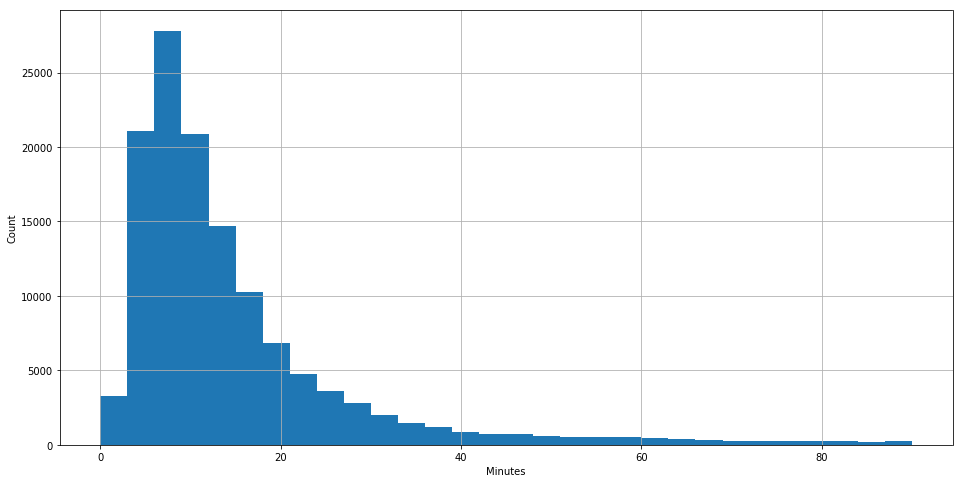

In [137]:
dataset.Duration = duration
plt.figure(figsize=(16, 8))
dataset.Duration.hist(bins=30, range=(0, 90))
plt.xlabel("Minutes")
plt.ylabel("Count")

In [8]:
duration.describe()

,0
count,132425.000000
mean,24.167159
std,79.571959
min,1.000000
25%,6.000000
50%,10.000000
75%,18.000000
max,1439.000000


### Какие тарифные планы пользуются большей популярностью у покупателей?


In [138]:
import seaborn as sns
from collections import Counter
for days, count in Counter(dataset["Plan Duration"].fillna("nan")).items():
    print("days = {}, count = {}, percentage = {}%".format(days, count, int(100*count/len(dataset))))

days = 30.0, count = 80920, percentage = 61%
days = 365.0, count = 9517, percentage = 7%
days = 0.0, count = 41222, percentage = 31%
days = nan, count = 766, percentage = 0%


По результатам видно, что montly plan приобрело наибольшее количество человек, 61% от общего числа пользователей сервиса. Данную информацию можно использовать в маркетинговых целях для акций, скидок на данный план.

### Есть ли какой-то велосипед, который берут чаще? чтобы знать какой пользуются большим спросом, и какой нужно чаще менять или ремонтировать

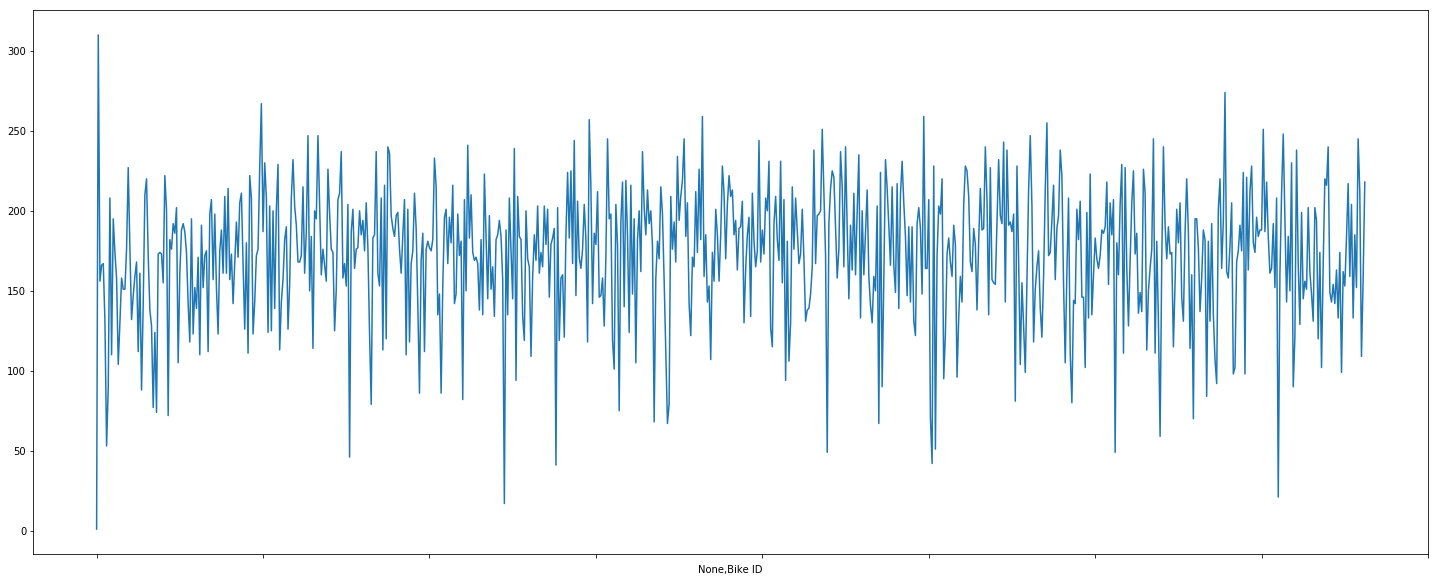

Наиболее часто используемый велосипед: 4727.0


In [280]:
idmax = dataset[['Bike ID','Trip ID']].groupby('Bike ID').count().unstack()
idmax.plot(figsize=(25,10))
plt.show()
print("Наиболее часто используемый велосипед:",idmax.idxmax()[1])

Наиболее часто используемый велосипед: 4727.0

### Есть ли станция, где чаще всего сдают/берут велосипеды?
На этой станции можно увеличить число велосипедов, сотрудников, поставить дополнительные услуги, бутыли с водой, открыть кафе или специализированный магазин для увеличения прибыли компании.

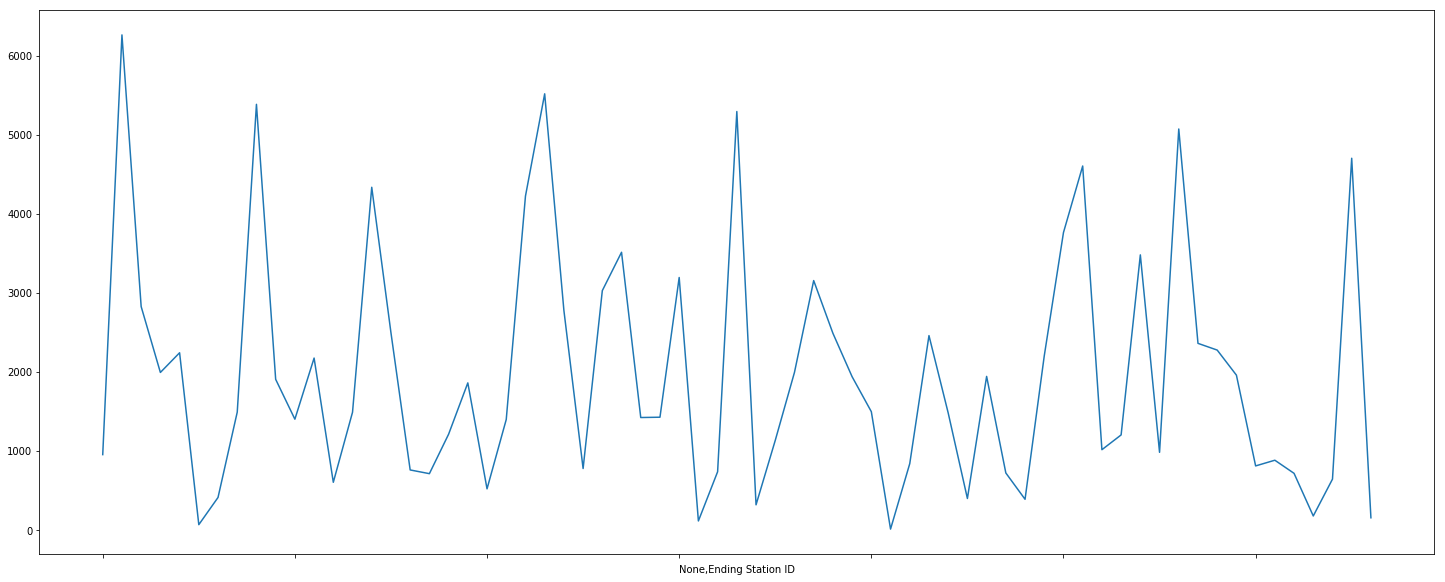

Наиболее часто используемая станция: 3005.0


In [140]:
idmax = dataset[['Starting Station ID','Ending Station ID']].groupby('Ending Station ID').count().unstack()
idmax.plot(figsize=(25,10))
plt.show()
print("Наиболее часто используемая станция:",idmax.idxmax()[1])

### По каким дням чаще всего берут велосипеды?
В эти дни можно также устраивать акциии и скидки и готовиться к повышенному спросу.

In [141]:
import datetime
from collections import Counter
format = "%Y-%m-%d"
start_time = pd.to_datetime(dataset["Start Time"], format=format).dt.day_name()
counts = Counter(start_time)
counts

Counter({'Thursday': 20345,
         'Friday': 20041,
         'Saturday': 18530,
         'Sunday': 17303,
         'Monday': 17251,
         'Tuesday': 19136,
         'Wednesday': 19819})

In [142]:
start_time.describe()

count       132425
unique           7
top       Thursday
freq         20345
Name: Start Time, dtype: object

Как видно, по пятницам (20041) и четвергам (20345) совершается наибольшее количество поездок.

### Построение линейной регрессии для переменных длительности поездки и типа поездки (в один конец, туда-обратно)


In [270]:
X = dataset['Duration'].values
X = X.reshape(-1, 1)
Y = dataset['Trip Route Category'].values
Y = Y.reshape(-1, 1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 1/3, random_state = 0)
from sklearn.linear_model import LinearRegression

reg = LogisticRegression(C=4)
reg.fit(X_train, y_train.ravel())
reg.score(X_train, y_train), reg.score(X_test, y_test)


(0.9021875356044207, 0.9024951577987923)

In [272]:
#построение дерева решений

from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
tree.score(X_train, y_train), tree.score(X_test, y_test)

(0.909718582659223, 0.9051840036458927)

In [273]:


#ПОСТРОЕНИЕ МОДЕЛЕЙ АНСАМБЛЕЙ


from sklearn.ensemble import BaggingClassifier
from sklearn import model_selection
modelBag = BaggingClassifier(base_estimator=reg, n_estimators=100, random_state=5)
results = model_selection.cross_val_score(modelBag, X_train, y_train.ravel(), cv=3) # прогоняем с помощью кросс-валидации без обучающей выборки
# результаты кросс-валидации
results


array([0.90166456, 0.90234816, 0.90248154])

In [274]:
results.mean()

0.9021647523845262

In [275]:
from sklearn.ensemble import BaggingClassifier
from sklearn import model_selection
modelBag = BaggingClassifier(base_estimator=tree, n_estimators=100, random_state=5)
resultsBag = model_selection.cross_val_score(modelBag, X_train, y_train.ravel(), cv=3) # прогоняем с помощью кросс-валидации без обучающей выборки
# результаты кросс-валидации
resultsBag

array([0.90433059, 0.90405715, 0.90425896])

In [276]:
resultsBag.mean()

0.90421556389873

In [277]:
from sklearn.ensemble import VotingClassifier
modelVote = VotingClassifier(estimators=[('lr', reg), ('dt', tree)], voting='hard')
modelVote.fit(X_train,y_train.ravel()) #обучающая выборка
modelVote.score(X_train,y_train), modelVote.score(X_test,y_test)
resultsV = model_selection.cross_val_score(modelVote, X_train, y_train.ravel(), cv=3)
resultsV

D:\Progs\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\Progs\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\Progs\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\Progs\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to c

array([0.90371535, 0.90371535, 0.90360952])

In [250]:
resultsV.mean()

0.9035661408237354

In [278]:
modelBag.fit(X_train, y_train.ravel())
modelBag.score(X_train, y_train), modelBag.score(X_test, y_test)

(0.9097071892446166, 0.9049561353537655)

In [279]:
pred1_train = pd.DataFrame(modelBag.predict(X_train))
pred2_train = pd.DataFrame(modelVote.predict(X_train))
pred1_test = pd.DataFrame(modelBag.predict(X_test))
pred2_test = pd.DataFrame(modelVote.predict(X_test))

data_train = pd.concat([pred1_train, pred2_train], axis=1)
data_test = pd.concat([pred1_test, pred2_test], axis=1)

modelSt = LogisticRegression()
modelSt.fit(data_train,y_train.ravel())
modelSt.score(data_train, y_train), modelSt.score(data_test, y_test)

D:\Progs\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\Progs\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


(0.9097071892446166, 0.9049561353537655)

In [63]:
resultsSt = model_selection.cross_val_score(modelSt, X_train, y_train.ravel(), cv=3)
resultsSt

array([0.9027117 , 0.90315346, 0.90352397])

In [64]:
resultsSt.mean()

0.9031297123371683

### Для другой части анализа используем урезанную таблицу и оставим только несколько нужных колонок.


In [148]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction import FeatureHasher
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
names = ['Duration', 'Bike ID', 'Plan Duration', 'Trip Route Category']
dataset = pd.read_csv("D:\los-angeles-metro-bike-share-trip-data\metro-bike-share-trip-data2.csv", header = 0, sep = ";" ,
                      low_memory=False)
dataset = dataset.dropna(0)
dataset.head()

,Trip ID,Duration,Bike ID,Plan Duration,Trip Route Category
0,1912818,180.0,6281.0,30.0,1.0
1,1919661,1980.0,6281.0,30.0,1.0
2,1933383,300.0,5861.0,365.0,1.0
3,1944197,10860.0,5861.0,365.0,1.0
4,1940317,420.0,6674.0,0.0,1.0


### Сделаем предположение о зависимости Длительности поездки 'Duration' от типа поездки 'Trip Route Category'.
Делим данные на тестовую и обучающие выборки и применяем к ним метод логистической регрессии, чтобы проверить или опровернуть предположение о том, будет ли оказывать тип поездки на ее длительность. Гипотеза: да, в зависимости от типа поездки 'One-way' (1) и 'Round Trip' (2) будет меняется длительность поездки.

In [237]:
import eli5
X = dataset.iloc[:, 0:4].values
y = dataset.iloc[:, 4].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/3, random_state = 0)

In [238]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# логистическая регрессия
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
logreg.score(X_train, y_train), logreg.score(X_test, y_test)

(0.9025863051156432, 0.9028597470661958)

Логистическая регрессия показала высокие значения как на обучающей выборке, так и на тестовой, соответственно зависимость есть.

### Попробуем метод деревьев

In [239]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
tree.score(X_train, y_train), tree.score(X_test, y_test)

(1.0, 0.8707758915346929)

In [240]:
tree.feature_importances_

array([0.4117874 , 0.2962083 , 0.26955933, 0.02244497])

In [241]:
import eli5
feat_imp_tree = eli5.explain_weights_df(tree, feature_names=names[0:4])
feat_imp_tree

,feature,weight
0,Duration,0.411787
1,Bike ID,0.296208
2,Plan Duration,0.269559
3,Trip Route Category,0.022445


Вес параметра Duration показал наибольшее значение.
Проверим с помощью функции библиотеки Lime проверить влияние этого параметра. 

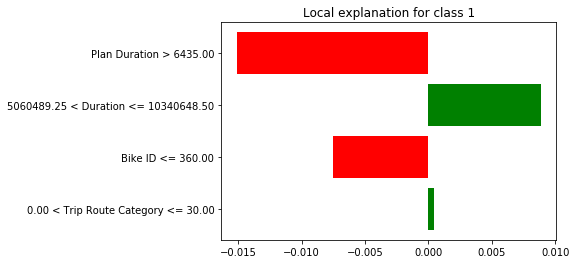

In [242]:
import lime
from lime.lime_tabular import LimeTabularExplainer
explainer = LimeTabularExplainer(X_train, mode='classification', 
                                 feature_names=names[0:4]) 
exp = explainer.explain_instance(X_test[2,:], 
                                 logreg.predict_proba)
a = exp.as_pyplot_figure()

In [243]:
exp.show_in_notebook()

In [244]:
explainer2 = LimeTabularExplainer(X_train, mode='classification', 
                                 feature_names=names[0:4], 
                                 discretize_continuous=False) 

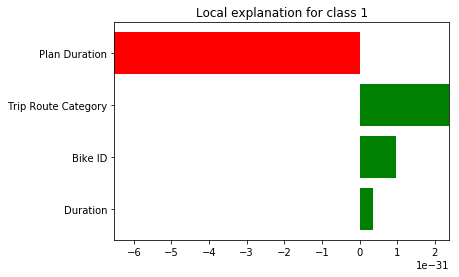

In [264]:
exp2 = explainer2.explain_instance(X_test[4,:], 
                                 logreg.predict_proba)
exp2.as_pyplot_figure();

Проверим предположения на другой модели линейной регрессии. Заново устанавливаем значения для переменных и делим выборку на 1/5 обучающей и 4/5 тестовой и прогоняем ее через линейную регрессию

In [265]:
X = dataset['Duration'].values
X = X.reshape(-1, 1)
Y = dataset['Trip Route Category'].values
Y = Y.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/5, random_state = 4)

reglab = LinearRegression()
reglab.fit(X_train,y_train)
reglab.intercept_, reglab.coef_ #выводим независимый член регрессии и оценочный коэффициент

(0.08775741053710912, array([5.08858766e-06]))

Возвращает коэффициент предсказания R^2, в идеале должен быть 1, у нас значение сильно меньше 1, поэтому нельзя рассматривать данную зависимость между переменными для предсказаний. Соответственно график будет не информативный.

In [266]:
reglab.score(X_train,y_train)

0.00994516086665942

Text(0,0.5,'Реальные значения')

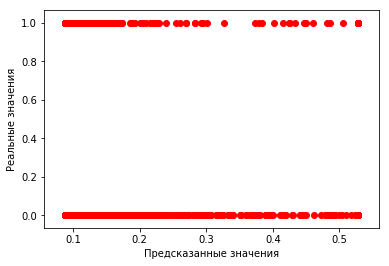

In [267]:
y_pred = reglab.predict(X_test)
plt.scatter(y_pred,y_test,color = 'red')
plt.xlabel('Предсказанные значения')
plt.ylabel("Реальные значения")

## Выводы:
- Логистическая регрессия показала лучшее значение среди всех моделей. Есть взаимосвязь между длительностью поездки и типом поездки.
- Cредняя длительность поездки = 24 минуты, соответственно организации необходимо размещать станции для сдачи велосипеда на расстоянии, которое можно преодолеть в пределах 30 минутной поездки для удобства клиентов.
- Montly plan пользуется наибольшей поплуряностью, 61% от общего числа пользователей сервиса. Данную информацию можно использовать в маркетинговых целях для акций, скидок на данный план.
- Велосипед, который чаще всего используется: 4727 (подлежит ремонту/замене)
- Станция, которая пользуется спросом № 3005, можно монетизировать данныю точку путем открытия кафе или магазина рядом с ней , и поставить большее количество велосипедов для удовлетворения спроса
- По четвергам и пятница чаще всего берут велосипеды, владельцы могут устраивать акции для привлечения покупателей.